In [1]:
using Distributions, PyPlot

In [127]:
##Generate some pks 
N = 20
q = .75
b = q/(1-q)
h = 1

K = 100
ps = rand(K)

#Expected Obj at alpha
function obj_k(alpha, p, p0)
    dist = Binomial(N, p)
    b * p + (1-cdf(dist, (q - alpha * p0)/(1-alpha) * N) ) * (1-p-b*p)
end
obj(alpha, ps, p0)= mean(map(p-> obj_k(alpha, p, p0), ps))


obj (generic function with 1 method)

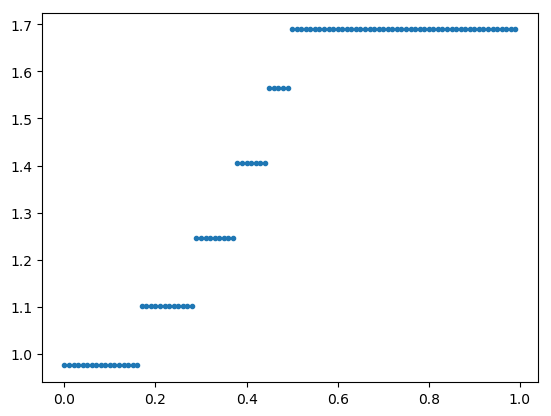

0.0

In [128]:
#What is optimal alpha?
p0 = .5
alpha_grid = linspace(0, .99, 100)
out = map(a->obj(a, ps, p0), alpha_grid)

# out = map(a-> (q - a * p0)/(1-a) * N, alpha_grid)
plot(alpha_grid, out, ".")

alphaOR = alpha_grid[indmin(out)]

#Observations:
# ##Only a benefit if p0 > q
# ## Not yet clear what optimal value is...

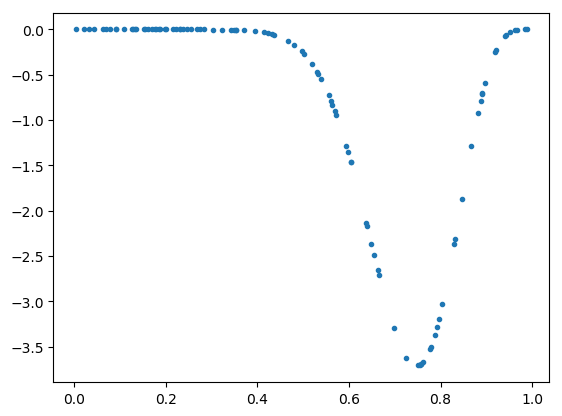

(-3.7076514372111924, 4.1983272408563366e-6)

In [106]:
#Questions:  1)  What is optimal shrinkage?
#            2)   What drives this?  Is it an importance sampling argument?

saa_objs = map(p->obj_k(0, p, p0), ps)
objs_alpha = map(p-> obj_k(.75, p, p0), ps)
deriv = map(p->obj_k(0.2, p, p0), ps)
deriv = (deriv-saa_objs)/.2

# plot(ps, saa_objs, ".b")
# plot(ps, objs_alpha, ".r")
plot(ps, deriv, ".")
minimum(deriv), maximum(deriv)

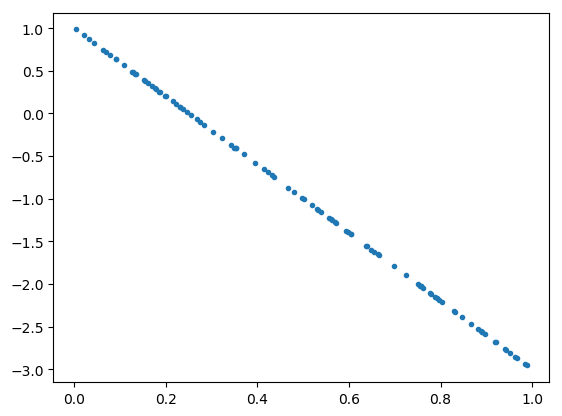

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x134ec0650>

In [116]:
out = map(p-> (1-p-b*p), ps)
plot(ps, out, ".")